# Time Series Analyses of Leafy Spurge with Linear Regression

This notebook performs linear regression on time-series raster pixel values. We perform a linear regression on the pixel values over time to estimate the slope of the trendline, which indicates the overall direction and rate of change over time. 

Linear regression models the relationship between two variables by fitting a straight line through the data points. In the case of change detection, the independent variable is time, and the dependent variable is the pixel value. The slope of the fitted line represents the rate of change over time. A positive slope indicates an increase in the pixel value, while a negative slope indicates a decrease.

These analyses are designed to support the time-series analyses of invasive species leafy spurge using multi-date Landsat satellite image remote sensing.

Author: Thomas A. Lake


# Python General Packages & Imports

In [1]:


#Time series analyses of each pixel in stacked rasters


import geopandas as gpd
import rasterio as rio
from rasterio import features
from rasterio.mask import mask
from rasterio.plot import show
import glob
import time
import itertools
from scipy import stats
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Time-series regressions on large .tif files are performed in a parallel Python environment

Note: Depending on the extent of pixel downsampling (mean aggregation) with the block_reduce function, these analyses may have high RAM memory requirements.

In [53]:

# Read in 10 predictions of leafy spurge from 1989 to 2019, then run linear regressions on each pixel as proability ~ time.
# The output of the regressions support inference of invasive species population monitoring.


# List all .tif files in /rasters folder for prediction, in chronological order
#tif_image_list = glob.glob(image_path + 'mean_mosaic_*_thinmodel_spurge.tif')


years_list = [1989, 1992, 1995, 1998, 2001, 2004, 2007, 2010, 2014, 2019]
years_array = np.array(years_list)
# Make it a 2-dimensional array to start
years_array = years_array.reshape((1, years_array.shape[0]))


# ordered list of .tif files for analyses
ordered_files = ['/scratch.global/lakex055/spurge_mosaic_predictions/mean_mosaic_1989_thinmodel_spurge.tif',
                 '/scratch.global/lakex055/spurge_mosaic_predictions/mean_mosaic_1992_thinmodel_spurge.tif',
                 '/scratch.global/lakex055/spurge_mosaic_predictions/mean_mosaic_1995_thinmodel_spurge.tif',
                 '/scratch.global/lakex055/spurge_mosaic_predictions/mean_mosaic_1998_thinmodel_spurge.tif',
                 '/scratch.global/lakex055/spurge_mosaic_predictions/mean_mosaic_2001_thinmodel_spurge.tif',
                 '/scratch.global/lakex055/spurge_mosaic_predictions/mean_mosaic_2004_thinmodel_spurge.tif',
                 '/scratch.global/lakex055/spurge_mosaic_predictions/mean_mosaic_2007_thinmodel_spurge.tif',
                 '/scratch.global/lakex055/spurge_mosaic_predictions/mean_mosaic_2010_thinmodel_spurge.tif',
                 '/scratch.global/lakex055/spurge_mosaic_predictions/mean_mosaic_2014_thinmodel_spurge.tif',
                 '/scratch.global/lakex055/spurge_mosaic_predictions/mean_mosaic_2019_thinmodel_spurge.tif']



# Define the desired output shape
n_rows = 44533
n_cols = 115031

# Create a placeholder array of zeros
base_array = np.zeros((n_rows, n_cols * len(ordered_files)))

# Combine array data from multiple files

for i, each_file in enumerate(ordered_files):
    year = years_list[i]

    # Open the file, read in as an array
    with rio.open(each_file) as src:
        arr = src.read(1)
        shp = arr.shape
        print(shp)
        
        # Downsample the raster by averaging over blocks of size 100x100 pixels
        arr = block_reduce(arr, block_size=(100, 100), func=np.mean)
        shp = arr.shape
        print(shp)              

        arr_flat = arr.reshape((shp[0] * shp[1], 1))
        #print(arr_flat.shape)

        # For the very first array, use it as the base
        if i == 0:
            base_array = arr_flat
            continue  # skip to the next year

        # Stack the arrays from each year
        base_array = np.concatenate((base_array, arr_flat), axis=1)
        print(base_array.shape)

        
        
# Create an array for the X data, or independent variable, i.e., the year
shp = base_array.shape
years_array = np.repeat(years_array, shp[0], axis = 0).reshape((shp[0], shp[1], 1))
base_array = base_array.reshape((shp[0], shp[1], 1))

# Now, combine X and Y data
base_array = np.concatenate((years_array, base_array), axis = 2)

print(base_array.shape) # (P, 10, 2)


# since we want to calculate regressions on every one of P total pixels is to map the stats.linregress() function over all pixels. 
# We'll define a function to do just this, as below. The first (zeroth) element in the sequence that is returned is the slope, which is what we want.

# Function maps result = [stats.linregress(array[i,...])[1] to return intercept, or [0] to return slope.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

#def linear_trend(array):
#    N = array.shape[0]
#    result = [(stats.linregress(array[i,...])[0], stats.linregress(array[i,...])[1]) for i in range(0, N)] # return (slope, intercept) tuple for each pixelor rvalue [2] or stderr slope [4] or stderr intercept [5]
#    return result

def linear_trend(array):
    N = array.shape[0]
    result = []
    for i in range(N):
        slope, intercept, r_value, p_value, std_err = stats.linregress(array[i,...])
        r_squared = r_value**2
        result.append((slope, intercept, r_squared))
    return result



NUM_PROCESSES = 32

N = base_array.shape[0]
P = (NUM_PROCESSES + 1) # Number of breaks (number of partitions + 1)

# Break up the indices into (roughly) equal parts
partitions = list(zip(np.linspace(0, N, P, dtype=int)[:-1],
    np.linspace(0, N, P, dtype=int)[1:]))

# Final range of indices should end +1 past last index for completeness
work = partitions[:-1]
work.append((partitions[-1][0], partitions[-1][1] + 1))


print(work) #shape [(0, 44030), (44030, 88061)]

from concurrent.futures import ProcessPoolExecutor

# Split the master array, base_array, into subarrays defined by the
#   starting and ending, i and j, indices
with ProcessPoolExecutor(max_workers = NUM_PROCESSES) as executor:
    result = executor.map(linear_trend, [
        base_array[i:j,...] for i, j in work
    ])

    
regression = list(result)
result = np.concatenate(regression, axis = 0)

result.shape
# result[0:10, 0] slope
# result[0:10, 1] intercept
# result[0:10, 2] rsquared

print("done")



(44533, 115031)
(446, 1151)
(44533, 115031)
(446, 1151)
(513346, 2)
(44533, 115031)
(446, 1151)
(513346, 3)
(44533, 115031)
(446, 1151)
(513346, 4)
(44533, 115031)
(446, 1151)
(513346, 5)
(44533, 115031)
(446, 1151)
(513346, 6)
(44533, 115031)
(446, 1151)
(513346, 7)
(44533, 115031)
(446, 1151)
(513346, 8)
(44533, 115031)
(446, 1151)
(513346, 9)
(44533, 115031)
(446, 1151)
(513346, 10)
(513346, 10, 2)
[(0, 16042), (16042, 32084), (32084, 48126), (48126, 64168), (64168, 80210), (80210, 96252), (96252, 112294), (112294, 128336), (128336, 144378), (144378, 160420), (160420, 176462), (176462, 192504), (192504, 208546), (208546, 224588), (224588, 240630), (240630, 256673), (256673, 272715), (272715, 288757), (288757, 304799), (304799, 320841), (320841, 336883), (336883, 352925), (352925, 368967), (368967, 385009), (385009, 401051), (401051, 417093), (417093, 433135), (433135, 449177), (449177, 465219), (465219, 481261), (481261, 497303), (497303, 513347)]
done


# Export .tif results of slope, intercept, r-Squared values from regressions for each pixel in the time-series.

In [13]:

# Export raster of linear regression coefficients

import rasterio as rio
from rasterio.transform import from_origin

# Define the output file path and metadata
outpath = '/home/moeller/shared/leafy-spurge-demography/timeseries_linearmodels_prediction_mosaics_thinmodel/timeseries_linear_models_rsquared_mosaic_output_scaling3_90m.tif'

# Output prediction raster
out_meta = src.meta.copy()

# Calculate the new transform to ensure the same resolution as the source data
out_transform = from_origin(src.bounds.left, src.bounds.top, src.res[0]*10, src.res[1]*10) #Modify value (3) to match scaling parameter for linear models

# Update output metadata to specify a single band and the new transform
out_meta.update({'driver': 'GTiff',
                  'count': 1,
                  'width': output_array.shape[1],
                  'height': output_array.shape[0],
                  'dtype': rio.float32,
                  'crs': src.crs,
                  'transform': out_transform})

# Write the array to a raster file
with rio.Env(CHECK_DISK_FREE_SPACE=False):
    with rio.open(outpath, mode='w', **out_meta) as dst:
        dst.write(output_array, 1)





# Linear regression rasters for analyses of population trends.

Result array holds the slope/intercept/rsqaured values

Base_Array holds the year and prediction values

# Reshape regression results to match dimensions of input .tif rasters

In [ ]:

# Subset the intercept, slope, rsquared values from the resulting linear models in the 'result' array
intercept_array = np.array(result[..., 1]).reshape((446, 1151)) #change to reflect raster dimensions after block_reduce

slope_array = np.array(result[..., 0]).reshape((446, 1151)) #change to reflect raster dimensions after block_reduce

rsquared_array = np.array(result[..., 2]).reshape((446, 1151))

base_array_reshape = base_array.reshape((446, 1151, 10, 2))


# Data Exploration of Slope, Intercept regression coefficients for the time-series analyses.

In [69]:

import numpy as np

# Result array holds the slope/intercept values
#intercept_array = np.array(result[..., 0]).reshape((446, 1151))
#slope_array = np.array(result[..., 1]).reshape((446, 1151))

# Calculate summary statistics for intercept and slope arrays
intercept_mean = np.mean(intercept_array)
intercept_median = np.median(intercept_array)
intercept_std = np.std(intercept_array)
intercept_min = np.min(intercept_array)
intercept_max = np.max(intercept_array)

slope_mean = np.mean(slope_array)
slope_median = np.median(slope_array)
slope_std = np.std(slope_array)
slope_min = np.min(slope_array)
slope_max = np.max(slope_array)

# Print out the summary statistics
print("Intercept summary statistics:")
print(f"Intercept mean: {intercept_mean:.2f}")
print(f"Intercept median: {intercept_median:.2f}")
print(f"Intercept standard deviation: {intercept_std:.2f}")
print(f"Intercept minimum: {intercept_min:.2f}")
print(f"Intercept maximum: {intercept_max:.2f}")

print("Slope summary statistics:")
print(f"Slope mean: {slope_mean:.2f}")
print(f"Slope standard deviation: {slope_std:.2f}")
print(f"Slope minimum: {slope_min:.2f}")
print(f"Slope maximum: {slope_max:.2f}")



Intercept summary statistics:
Intercept mean: -26830.54
Intercept median: 0.00
Intercept standard deviation: 228988.64
Intercept minimum: -2848583.65
Intercept maximum: 2247518.80
Slope summary statistics:
Slope mean: 15.10
Slope standard deviation: 114.97
Slope minimum: -1109.33
Slope maximum: 1443.83


<AxesSubplot:>

Text(0.5, 1.0, 'Slope values across study region')

Text(0.5, 15.0, 'Column index')

Text(33.0, 0.5, 'Row index')

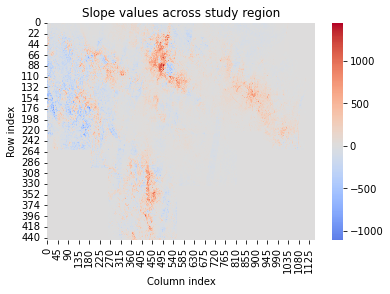

<AxesSubplot:>

Text(0.5, 1.0, 'Intercept values across study region')

Text(0.5, 15.0, 'Column index')

Text(33.0, 0.5, 'Row index')

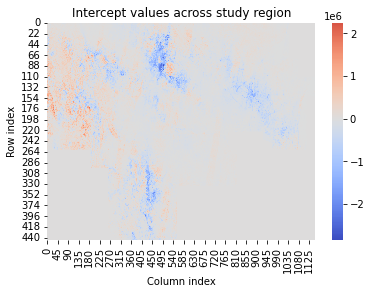

<AxesSubplot:>

Text(0.5, 1.0, 'Rsquared values across study region')

Text(0.5, 15.0, 'Column index')

Text(33.0, 0.5, 'Row index')

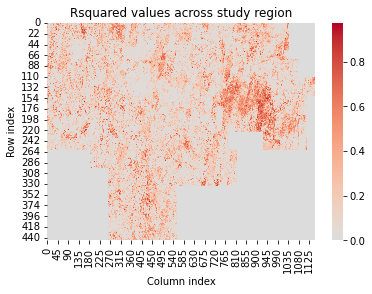

In [72]:
import seaborn as sns

# Create a heatmap of the slope values
sns.heatmap(slope_array, cmap="coolwarm", center=0)
plt.title("Slope values across study region")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()

sns.heatmap(intercept_array, cmap="coolwarm", center=0)
plt.title("Intercept values across study region")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()

sns.heatmap(rsquared_array, cmap="coolwarm", center=0)
plt.title("Rsquared values across study region")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()


<AxesSubplot:ylabel='Density'>

Text(0.5, 1.0, 'Distribution of Slope Values')

Text(0.5, 0, 'Slope')

Text(0, 0.5, 'Density')

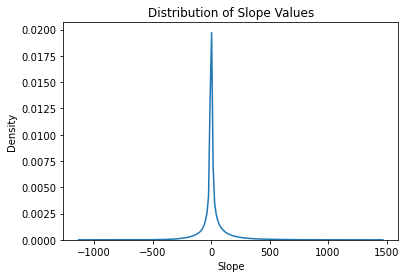

<AxesSubplot:ylabel='Density'>

Text(0.5, 1.0, 'Distribution of Intercept Values')

Text(0.5, 0, 'Intercept')

Text(0, 0.5, 'Density')

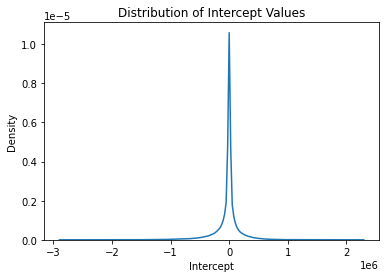

<AxesSubplot:ylabel='Density'>

Text(0.5, 1.0, 'Distribution of Rsquared Values')

Text(0.5, 0, 'Rsquared')

Text(0, 0.5, 'Density')

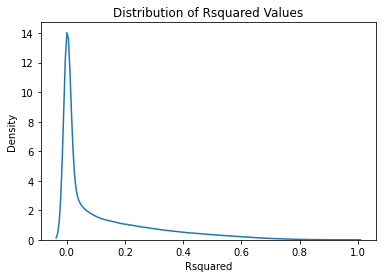

In [71]:
# Linear Model Prediction Plotting

import seaborn as sns

# Get the slope and intercept values
slope_values = slope_array.ravel()
intercept_values = intercept_array.ravel()
rsquared_values = rsquared_array.ravel()

# Create a KDE plot for slope values
sns.kdeplot(slope_values)
plt.title("Distribution of Slope Values")
plt.xlabel("Slope")
plt.ylabel("Density")
plt.show()

# Create a KDE plot for intercept values
sns.kdeplot(intercept_values)
plt.title("Distribution of Intercept Values")
plt.xlabel("Intercept")
plt.ylabel("Density")
plt.show()

# Create a KDE plot for intercept values
sns.kdeplot(rsquared_values)
plt.title("Distribution of Rsquared Values")
plt.xlabel("Rsquared")
plt.ylabel("Density")
plt.show()



# Select and Plot linear regressions for pixels


Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 64): y = 47.85x + -94873.40')

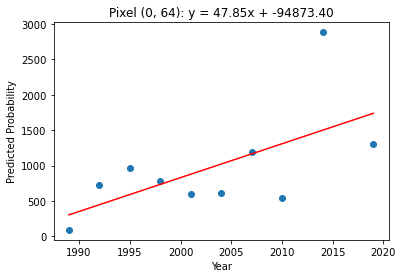

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 65): y = 28.75x + -57034.44')

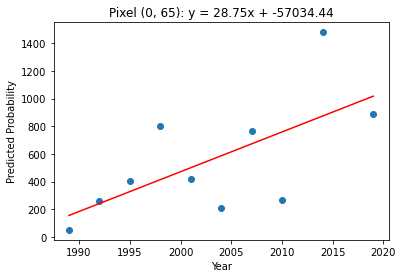

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 66): y = 50.27x + -99316.16')

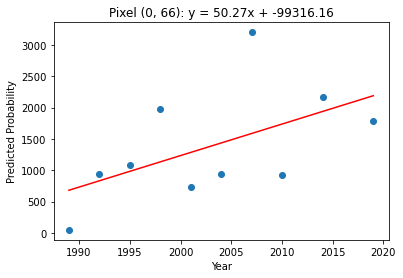

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 67): y = 55.22x + -108976.53')

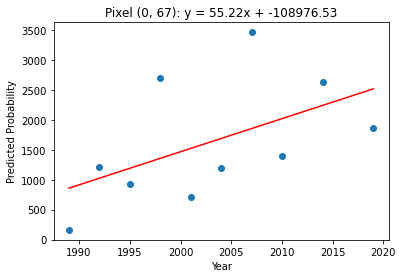

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 68): y = 49.46x + -97368.23')

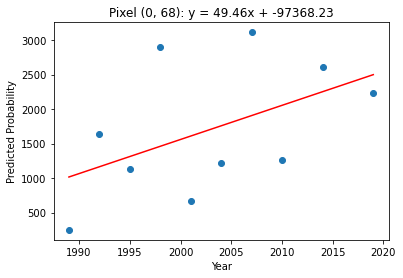

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 69): y = 74.88x + -148458.34')

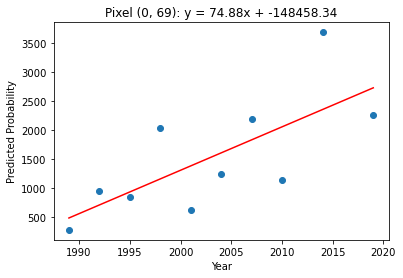

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 70): y = 56.24x + -111100.01')

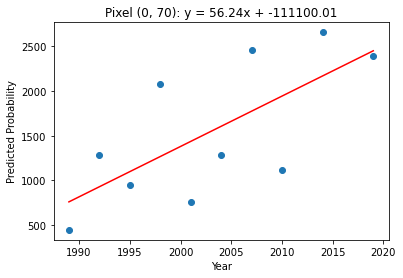

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 71): y = 64.08x + -126512.40')

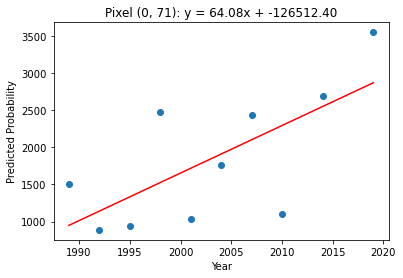

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 72): y = 60.37x + -118957.91')

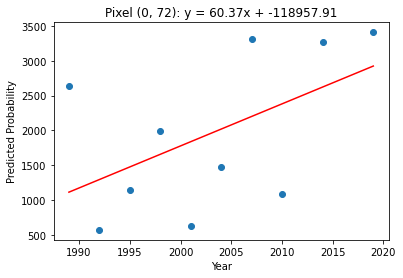

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 73): y = 61.56x + -121873.23')

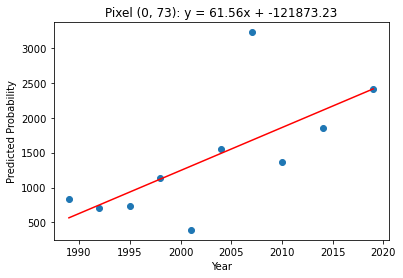

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 139): y = 14.26x + -27773.03')

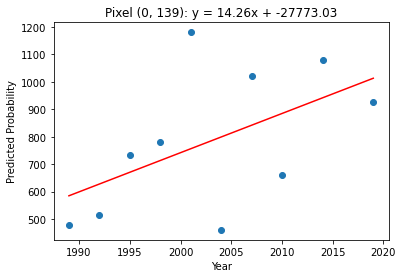

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 140): y = 13.49x + -26511.65')

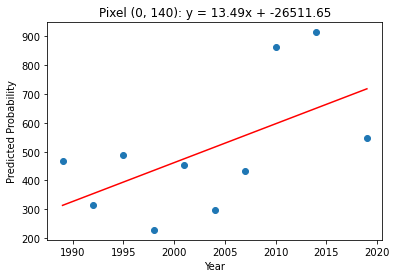

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 141): y = 11.87x + -23266.99')

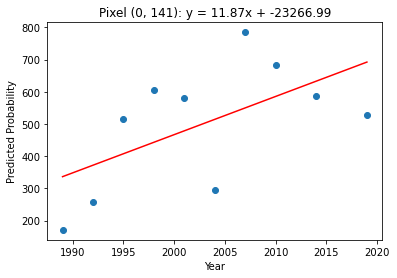

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 145): y = 16.08x + -31635.05')

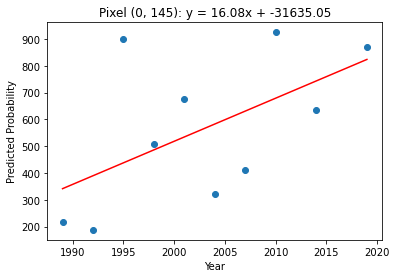

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 146): y = 21.41x + -42236.06')

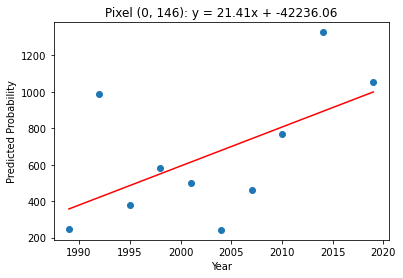

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 147): y = 19.45x + -38358.77')

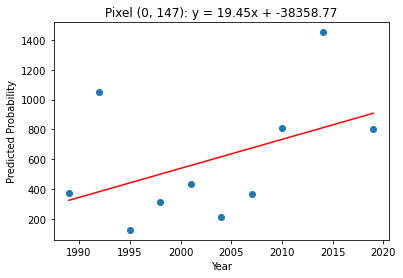

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 148): y = 10.64x + -20934.81')

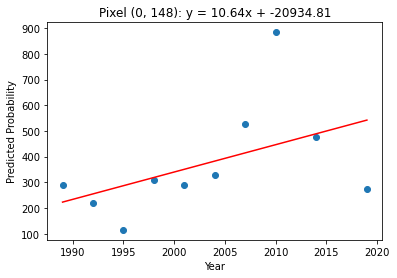

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 149): y = 10.24x + -20238.38')

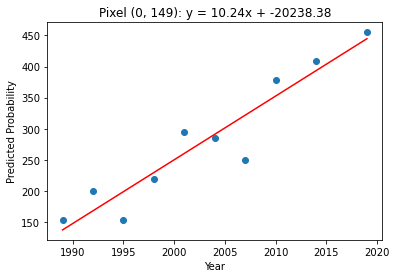

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 155): y = 13.50x + -26678.52')

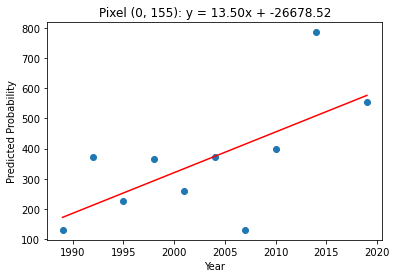

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 156): y = 6.64x + -13113.69')

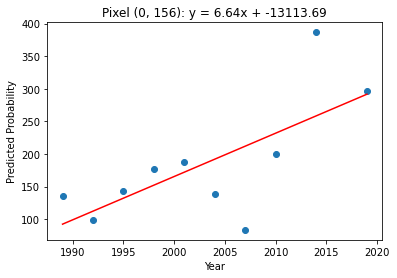

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 160): y = 10.09x + -19959.32')

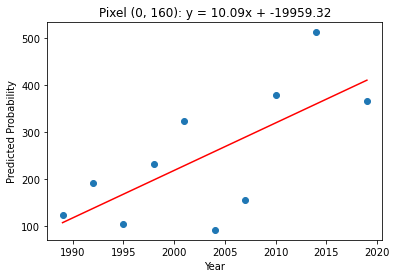

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 171): y = 1.97x + -3830.90')

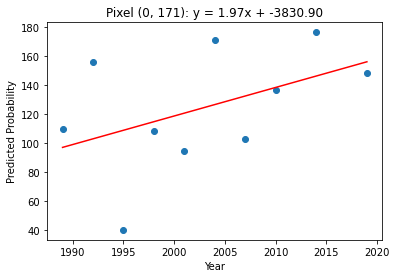

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 197): y = 8.43x + -16582.48')

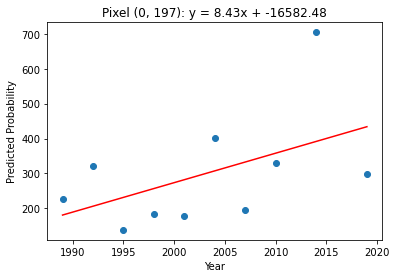

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 198): y = 18.92x + -37250.63')

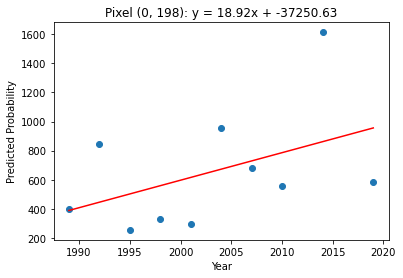

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 199): y = 26.24x + -52047.52')

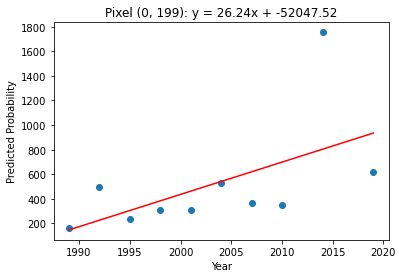

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 200): y = 11.88x + -23319.25')

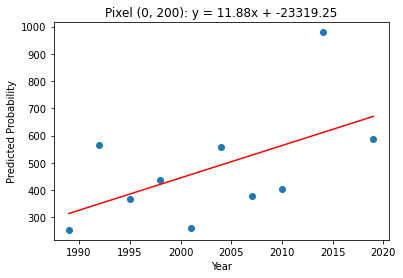

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 201): y = 22.77x + -45171.34')

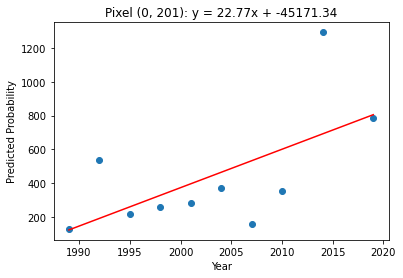

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 202): y = 32.16x + -63993.82')

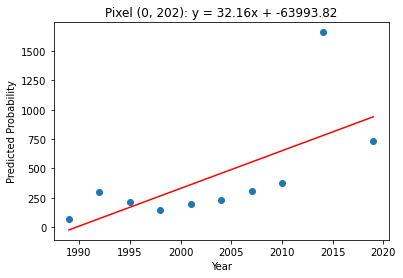

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 203): y = 39.40x + -78409.51')

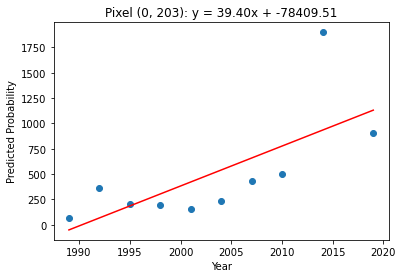

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 204): y = 36.70x + -72948.69')

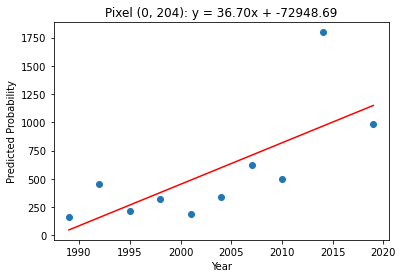

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 205): y = 44.29x + -88168.07')

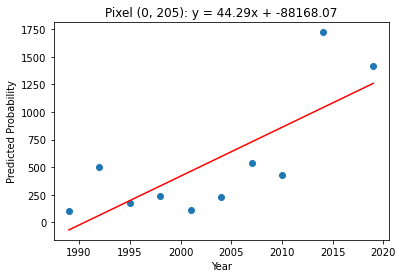

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 206): y = 37.49x + -74637.87')

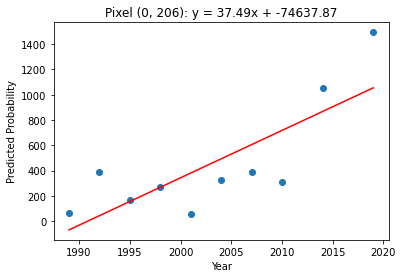

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 207): y = 38.45x + -76571.62')

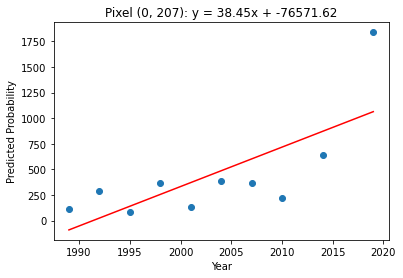

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 208): y = 28.53x + -56700.71')

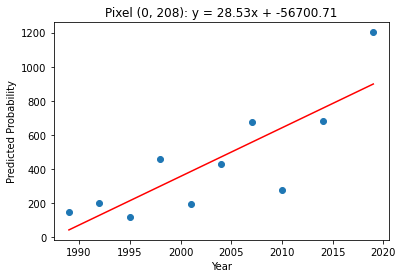

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 209): y = 36.96x + -73508.26')

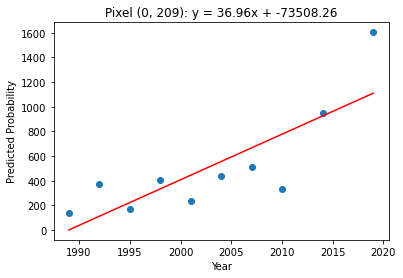

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 210): y = 45.17x + -89900.73')

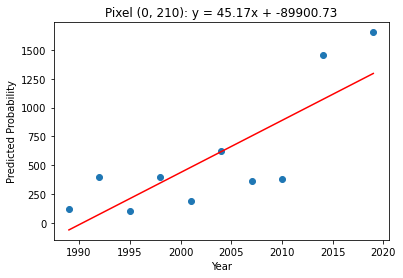

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 211): y = 34.35x + -68279.72')

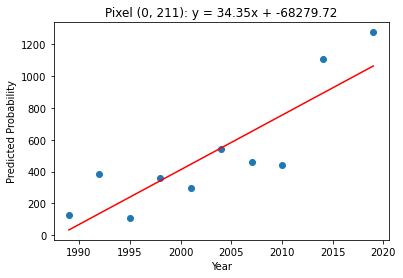

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 212): y = 42.28x + -84094.87')

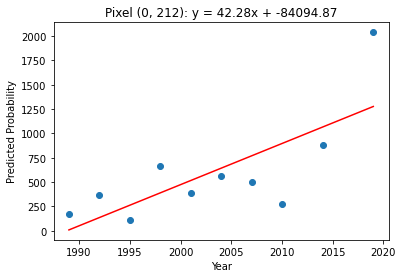

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 213): y = 39.89x + -79334.09')

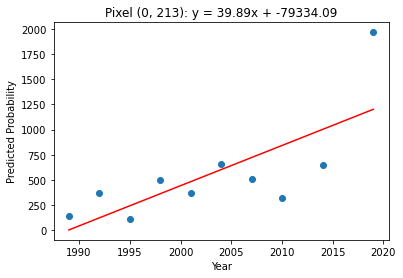

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 214): y = 36.12x + -71713.05')

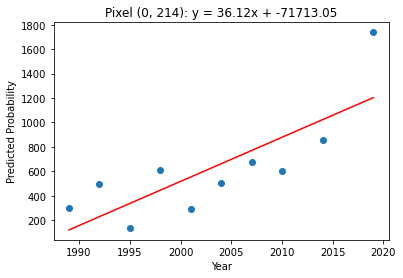

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 215): y = 17.59x + -34524.29')

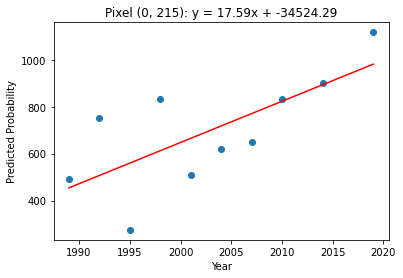

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 216): y = 10.43x + -20184.66')

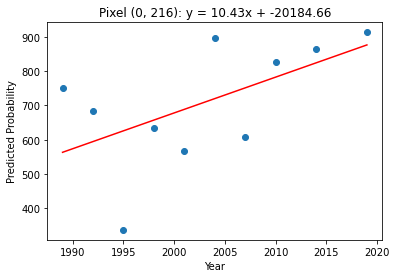

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 217): y = 18.39x + -36110.09')

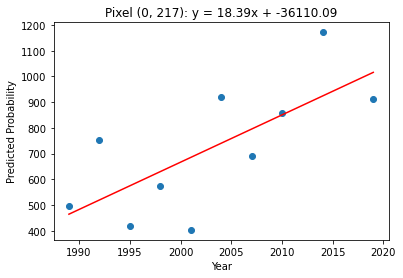

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 218): y = 28.20x + -55886.44')

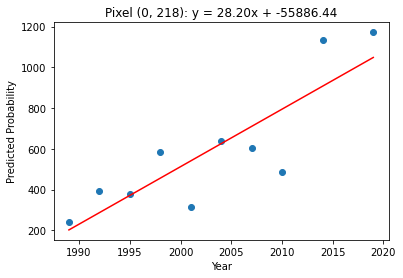

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 219): y = 38.26x + -76093.02')

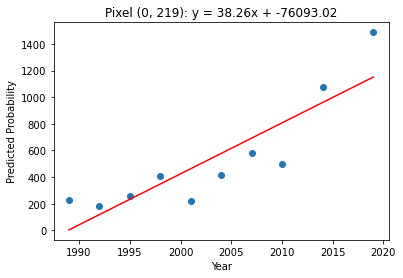

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 220): y = 43.12x + -85811.11')

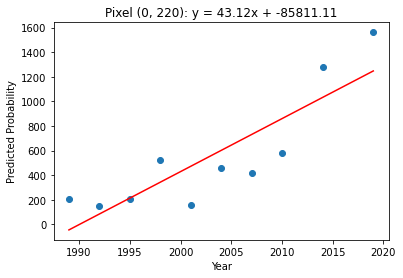

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 221): y = 24.59x + -48688.75')

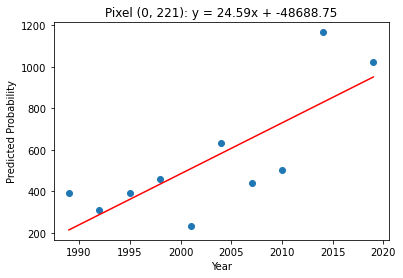

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 259): y = 21.18x + -41849.84')

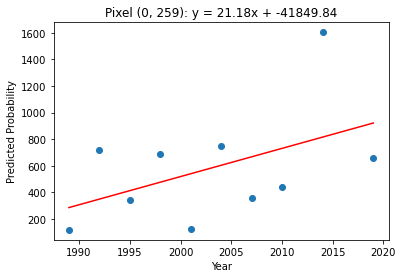

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 260): y = 20.89x + -41233.87')

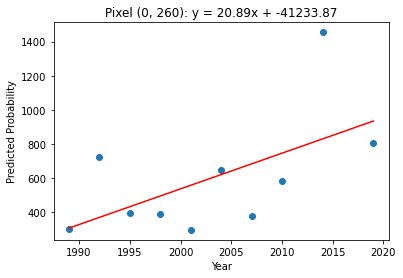

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Predicted Probability')

Text(0.5, 1.0, 'Pixel (0, 262): y = 11.93x + -23341.10')

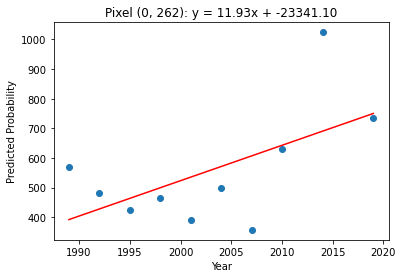

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [78]:
import matplotlib.pyplot as plt

# Plot linear model for each pixel
for i in range(base_array_reshape.shape[0]):
    for j in range(base_array_reshape.shape[1]):
        if slope_array[i, j] > 0:
            if rsquared_array[i, j] > 0.2:
                x = base_array_reshape[i, j, :, 0] # years
                y = base_array_reshape[i, j, :, 1] # predictions
                slope = slope_array[i, j]
                intercept = intercept_array[i, j]
                fig, ax = plt.subplots()
                ax.scatter(x, y)
                ax.plot(x, slope*x + intercept, color='red')
                ax.set_xlabel('Year')
                ax.set_ylabel('Predicted Probability')
                ax.set_title(f'Pixel ({i}, {j}): y = {slope:.2f}x + {intercept:.2f}')
                plt.show()


# Principal Compoonents Analyses and Correlation analyses between climate and topographic variables, for leafy spurge predictions (probability) and population change (slopes)

(8501, 37)
(8501,)
latitude               -0.021157
longitude               0.114338
prism_ppt              -0.073994
prism_mean_temp         0.055337
prism_min_temp          0.041932
prism_max_temp          0.059796
prism_dew_pt            0.051320
prism_vpmax             0.021147
prism_vpmin            -0.049410
Ca                     -0.010492
K                       0.029402
Mg                     -0.014271
P                      -0.083408
InorgC                  0.076927
OrgC                   -0.049754
b1_NA_wc2_BioClim19     0.072548
b2_NA_wc2_BioClim19     0.059532
b3_NA_wc2_BioClim19    -0.046898
b4_NA_wc2_BioClim19     0.114209
b5_NA_wc2_BioClim19     0.126686
b6_NA_wc2_BioClim19    -0.060600
b7_NA_wc2_BioClim19     0.148452
b8_NA_wc2_BioClim19     0.166753
b9_NA_wc2_BioClim19    -0.140234
b10_NA_wc2_BioClim19    0.120392
b11_NA_wc2_BioClim19   -0.025058
b12_NA_wc2_BioClim19   -0.008028
b13_NA_wc2_BioClim19    0.059558
b14_NA_wc2_BioClim19   -0.087823
b15_NA_wc2_BioClim19    

Text(0.5, 0, 'latitude')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'latitude vs. Response')

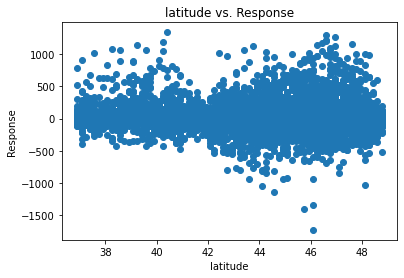

Text(0.5, 0, 'longitude')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'longitude vs. Response')

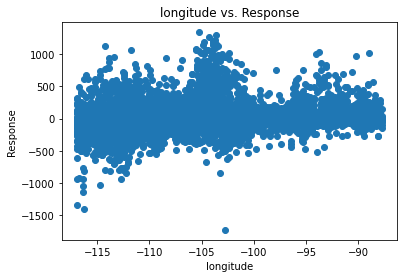

Text(0.5, 0, 'prism_ppt')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'prism_ppt vs. Response')

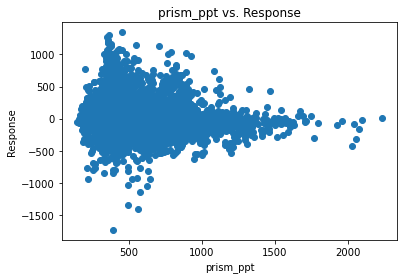

Text(0.5, 0, 'prism_mean_temp')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'prism_mean_temp vs. Response')

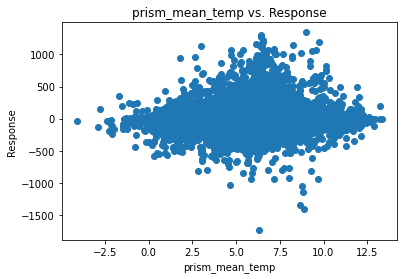

Text(0.5, 0, 'prism_min_temp')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'prism_min_temp vs. Response')

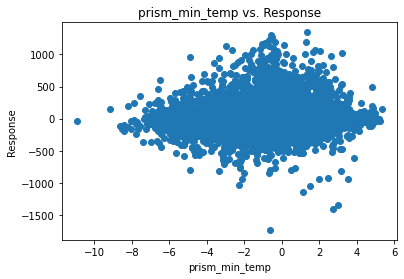

Text(0.5, 0, 'prism_max_temp')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'prism_max_temp vs. Response')

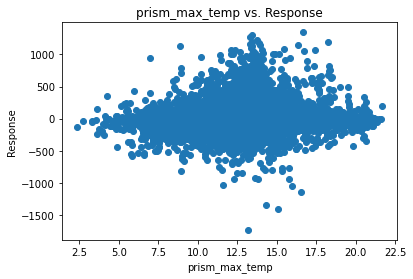

Text(0.5, 0, 'prism_dew_pt')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'prism_dew_pt vs. Response')

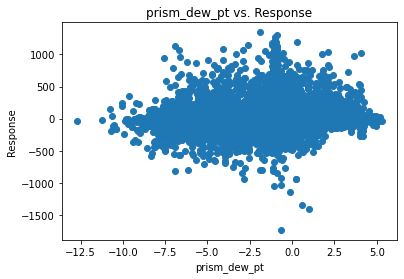

Text(0.5, 0, 'prism_vpmax')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'prism_vpmax vs. Response')

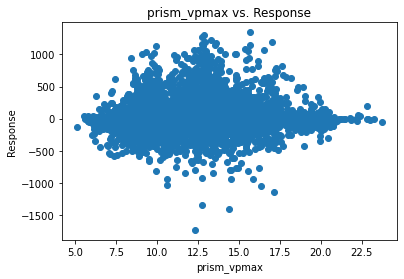

Text(0.5, 0, 'prism_vpmin')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'prism_vpmin vs. Response')

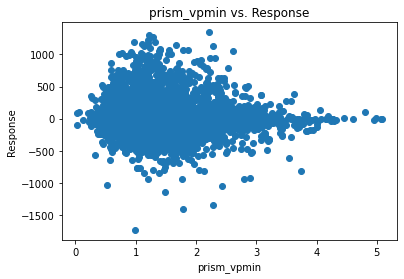

Text(0.5, 0, 'Ca')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'Ca vs. Response')

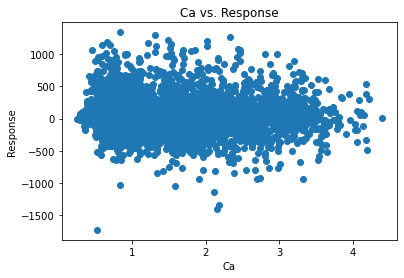

Text(0.5, 0, 'K')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'K vs. Response')

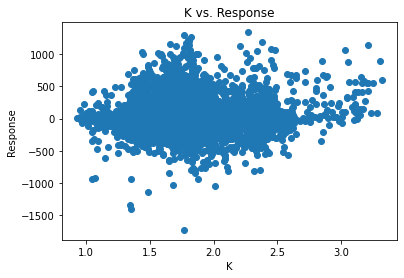

Text(0.5, 0, 'Mg')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'Mg vs. Response')

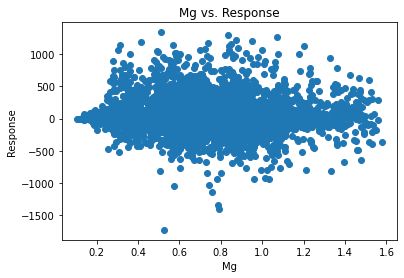

Text(0.5, 0, 'P')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'P vs. Response')

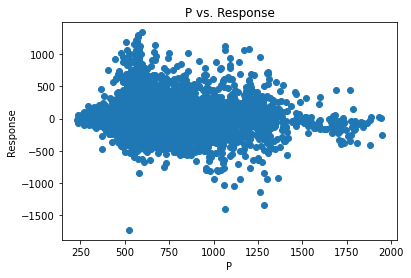

Text(0.5, 0, 'InorgC')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'InorgC vs. Response')

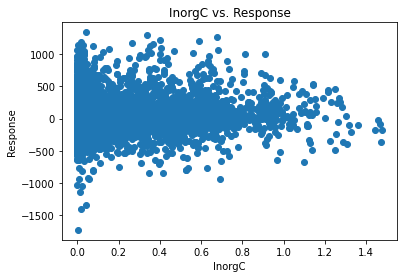

Text(0.5, 0, 'OrgC')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'OrgC vs. Response')

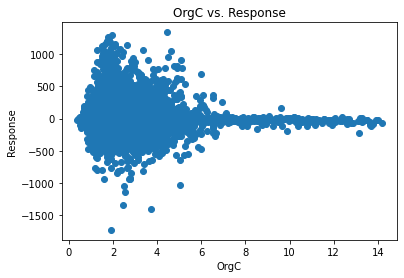

Text(0.5, 0, 'b1_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b1_NA_wc2_BioClim19 vs. Response')

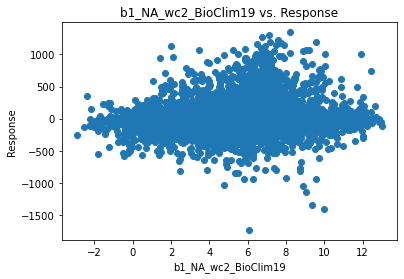

Text(0.5, 0, 'b2_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b2_NA_wc2_BioClim19 vs. Response')

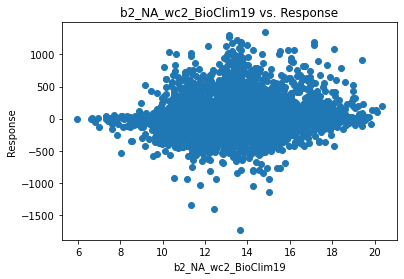

Text(0.5, 0, 'b3_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b3_NA_wc2_BioClim19 vs. Response')

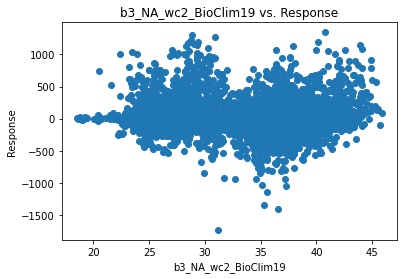

Text(0.5, 0, 'b4_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b4_NA_wc2_BioClim19 vs. Response')

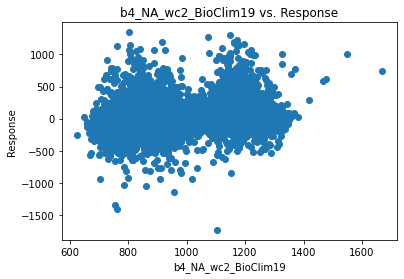

Text(0.5, 0, 'b5_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b5_NA_wc2_BioClim19 vs. Response')

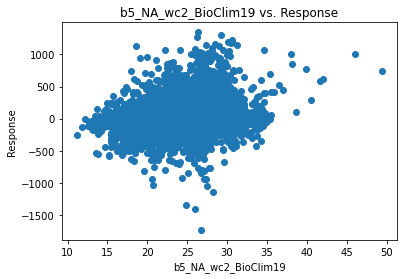

Text(0.5, 0, 'b6_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b6_NA_wc2_BioClim19 vs. Response')

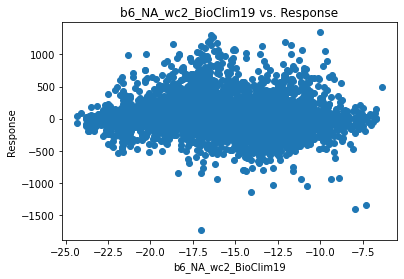

Text(0.5, 0, 'b7_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b7_NA_wc2_BioClim19 vs. Response')

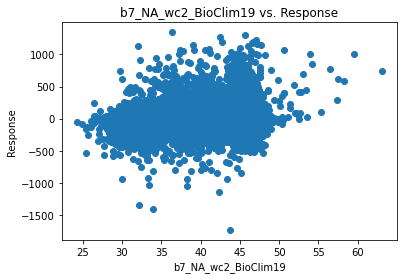

Text(0.5, 0, 'b8_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b8_NA_wc2_BioClim19 vs. Response')

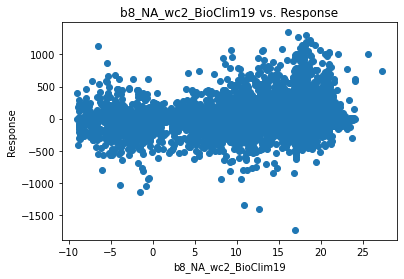

Text(0.5, 0, 'b9_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b9_NA_wc2_BioClim19 vs. Response')

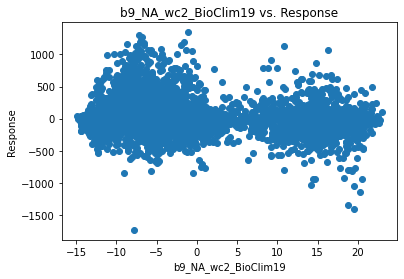

Text(0.5, 0, 'b10_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b10_NA_wc2_BioClim19 vs. Response')

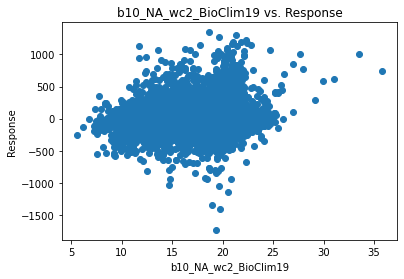

Text(0.5, 0, 'b11_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b11_NA_wc2_BioClim19 vs. Response')

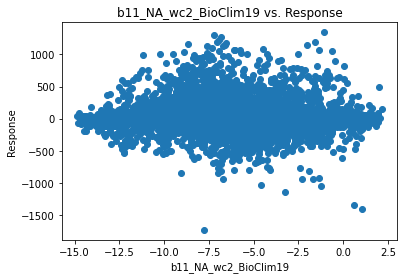

Text(0.5, 0, 'b12_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b12_NA_wc2_BioClim19 vs. Response')

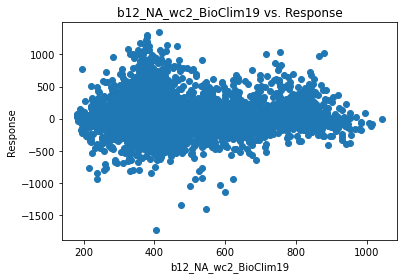

Text(0.5, 0, 'b13_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b13_NA_wc2_BioClim19 vs. Response')

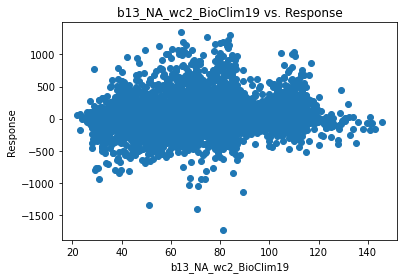

Text(0.5, 0, 'b14_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b14_NA_wc2_BioClim19 vs. Response')

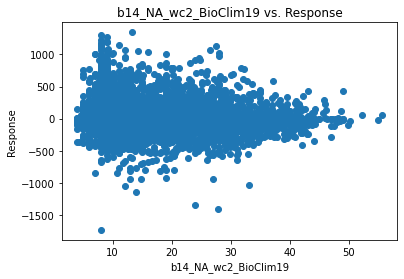

Text(0.5, 0, 'b15_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b15_NA_wc2_BioClim19 vs. Response')

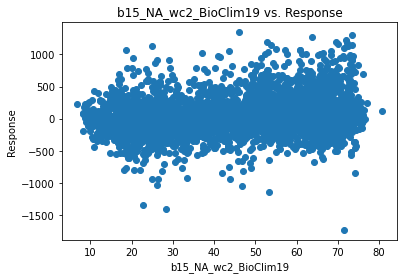

Text(0.5, 0, 'b16_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b16_NA_wc2_BioClim19 vs. Response')

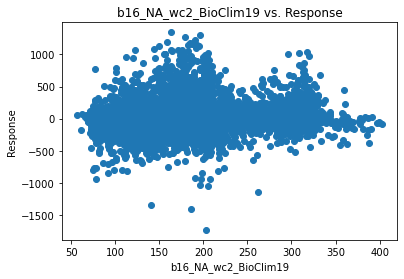

Text(0.5, 0, 'b17_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b17_NA_wc2_BioClim19 vs. Response')

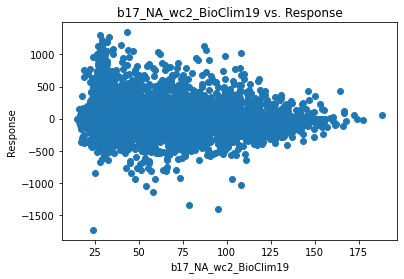

Text(0.5, 0, 'b18_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b18_NA_wc2_BioClim19 vs. Response')

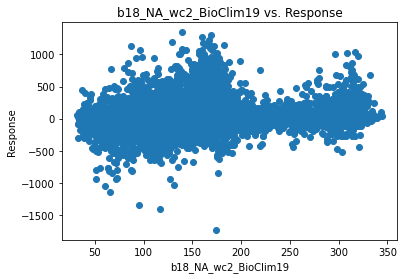

Text(0.5, 0, 'b19_NA_wc2_BioClim19')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'b19_NA_wc2_BioClim19 vs. Response')

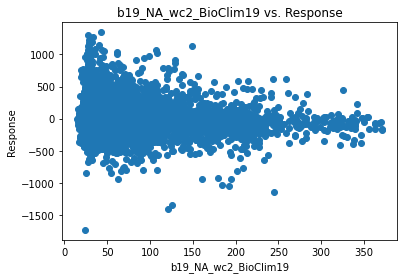

Text(0.5, 0, 'elevation_1KMmd_SRTM')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'elevation_1KMmd_SRTM vs. Response')

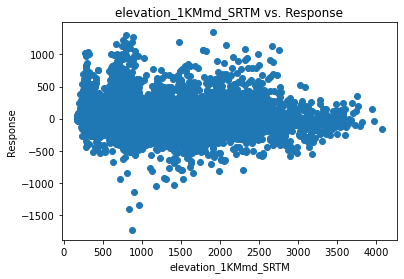

Text(0.5, 0, 'slope_1KMmd_SRTM')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'slope_1KMmd_SRTM vs. Response')

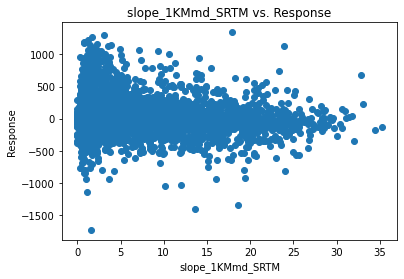

Text(0.5, 0, 'sdm')

Text(0, 0.5, 'Response')

Text(0.5, 1.0, 'sdm vs. Response')

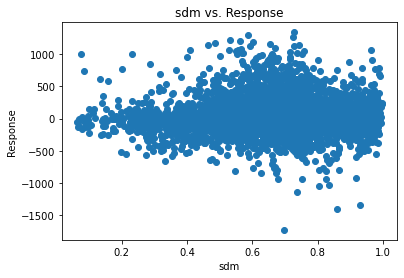

[Text(0, 0, 'latitude'),
 Text(1, 0, 'longitude'),
 Text(2, 0, 'prism_ppt'),
 Text(3, 0, 'prism_mean_temp'),
 Text(4, 0, 'prism_min_temp'),
 Text(5, 0, 'prism_max_temp'),
 Text(6, 0, 'prism_dew_pt'),
 Text(7, 0, 'prism_vpmax'),
 Text(8, 0, 'prism_vpmin'),
 Text(9, 0, 'Ca'),
 Text(10, 0, 'K'),
 Text(11, 0, 'Mg'),
 Text(12, 0, 'P'),
 Text(13, 0, 'InorgC'),
 Text(14, 0, 'OrgC'),
 Text(15, 0, 'b1_NA_wc2_BioClim19'),
 Text(16, 0, 'b2_NA_wc2_BioClim19'),
 Text(17, 0, 'b3_NA_wc2_BioClim19'),
 Text(18, 0, 'b4_NA_wc2_BioClim19'),
 Text(19, 0, 'b5_NA_wc2_BioClim19'),
 Text(20, 0, 'b6_NA_wc2_BioClim19'),
 Text(21, 0, 'b7_NA_wc2_BioClim19'),
 Text(22, 0, 'b8_NA_wc2_BioClim19'),
 Text(23, 0, 'b9_NA_wc2_BioClim19'),
 Text(24, 0, 'b10_NA_wc2_BioClim19'),
 Text(25, 0, 'b11_NA_wc2_BioClim19'),
 Text(26, 0, 'b12_NA_wc2_BioClim19'),
 Text(27, 0, 'b13_NA_wc2_BioClim19'),
 Text(28, 0, 'b14_NA_wc2_BioClim19'),
 Text(29, 0, 'b15_NA_wc2_BioClim19'),
 Text(30, 0, 'b16_NA_wc2_BioClim19'),
 Text(31, 0, 'b17_NA_w

[Text(0, 0, 'latitude'),
 Text(0, 1, 'longitude'),
 Text(0, 2, 'prism_ppt'),
 Text(0, 3, 'prism_mean_temp'),
 Text(0, 4, 'prism_min_temp'),
 Text(0, 5, 'prism_max_temp'),
 Text(0, 6, 'prism_dew_pt'),
 Text(0, 7, 'prism_vpmax'),
 Text(0, 8, 'prism_vpmin'),
 Text(0, 9, 'Ca'),
 Text(0, 10, 'K'),
 Text(0, 11, 'Mg'),
 Text(0, 12, 'P'),
 Text(0, 13, 'InorgC'),
 Text(0, 14, 'OrgC'),
 Text(0, 15, 'b1_NA_wc2_BioClim19'),
 Text(0, 16, 'b2_NA_wc2_BioClim19'),
 Text(0, 17, 'b3_NA_wc2_BioClim19'),
 Text(0, 18, 'b4_NA_wc2_BioClim19'),
 Text(0, 19, 'b5_NA_wc2_BioClim19'),
 Text(0, 20, 'b6_NA_wc2_BioClim19'),
 Text(0, 21, 'b7_NA_wc2_BioClim19'),
 Text(0, 22, 'b8_NA_wc2_BioClim19'),
 Text(0, 23, 'b9_NA_wc2_BioClim19'),
 Text(0, 24, 'b10_NA_wc2_BioClim19'),
 Text(0, 25, 'b11_NA_wc2_BioClim19'),
 Text(0, 26, 'b12_NA_wc2_BioClim19'),
 Text(0, 27, 'b13_NA_wc2_BioClim19'),
 Text(0, 28, 'b14_NA_wc2_BioClim19'),
 Text(0, 29, 'b15_NA_wc2_BioClim19'),
 Text(0, 30, 'b16_NA_wc2_BioClim19'),
 Text(0, 31, 'b17_NA_w

Text(0.5, 1.0, 'Correlation Matrix')

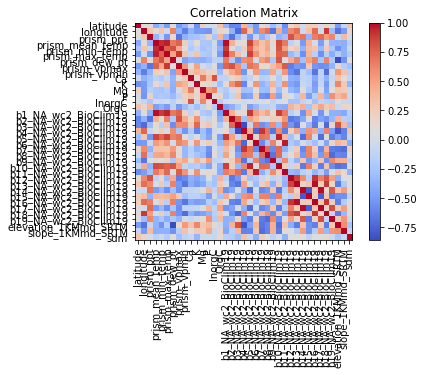

In [19]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

data = pd.read_csv(r'/home/moeller/shared/leafy-spurge-demography/Leafy_Spurge_PCA_Predicted_Climate_EnvVarbs.csv')

predictors = data.iloc[:, 4:]  # Exclude the first 4 columns (predicted value, slope, intercept, rsquared) and keep only environmental predictors
print(predictors.shape)

response = data.iloc[:, 1]  # response (predicted value of leafy spurge from 2019 model, slope, intercept, etc)
print(response.shape)

# Calculate the correlation matrix
correlation_matrix = predictors.corr()

# Calculate the correlation coefficients
correlation_coeffs = predictors.corrwith(response)
print(correlation_coeffs)

# Plot scatter plots of predictor variables and response
for column in predictors.columns:
    fig, ax = plt.subplots()
    ax.scatter(predictors[column], response)
    ax.set_xlabel(column)
    ax.set_ylabel('Response')
    ax.set_title(f'{column} vs. Response')
    plt.show()

# Plot correlation matrix as a heatmap
fig, ax = plt.subplots()
heatmap = ax.imshow(correlation_matrix, cmap='coolwarm')
ax.set_xticks(range(len(predictors.columns)))
ax.set_yticks(range(len(predictors.columns)))
ax.set_xticklabels(predictors.columns, rotation=90)
ax.set_yticklabels(predictors.columns)
plt.colorbar(heatmap)
plt.title('Correlation Matrix')
plt.show()


(8501, 37)
(8501,)


PCA()

Correlation between principal components and response variable:
Principal Component 1: -0.13
Principal Component 2: 0.05
Principal Component 3: -0.06
Principal Component 4: -0.02
Principal Component 5: 0.09
Principal Component 6: 0.03
Principal Component 7: 0.02
Principal Component 8: -0.04
Principal Component 9: -0.08
Principal Component 10: 0.02
Principal Component 11: -0.03
Principal Component 12: 0.07
Principal Component 13: 0.07
Principal Component 14: -0.08
Principal Component 15: -0.03
Principal Component 16: 0.01
Principal Component 17: -0.05
Principal Component 18: -0.07
Principal Component 19: 0.08
Principal Component 20: -0.03
Principal Component 21: 0.06
Principal Component 22: 0.03
Principal Component 23: 0.02
Principal Component 24: -0.01
Principal Component 25: -0.01
Principal Component 26: 0.12
Principal Component 27: 0.03
Principal Component 28: 0.06
Principal Component 29: 0.02
Principal Component 30: -0.06
Principal Component 31: -0.02
Principal Component 32: 0.01
Pr

Text(0.5, 0, 'Sample Index')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residuals Analysis')

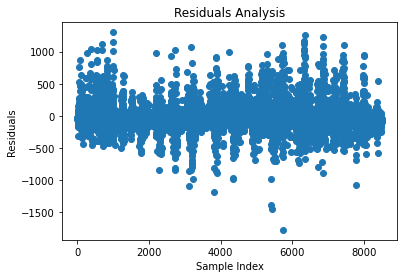

In [21]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

data = pd.read_csv(r'/home/moeller/shared/leafy-spurge-demography/Leafy_Spurge_PCA_Predicted_Climate_EnvVarbs.csv')

predictors = data.iloc[:, 4:]  # Exclude the first 4 columns (predicted value, slope, intercept, rsquared) and keep only environmental predictors
print(predictors.shape)

response = data.iloc[:, 1]  # response (predicted value of leafy spurge from 2019 model, slope, intercept, etc)
print(response.shape)

# Standardize the predictor variables
scaler = StandardScaler()
predictors_standardized = scaler.fit_transform(predictors)

# Perform PCA
pca = PCA()
pca.fit(predictors_standardized)

# Access the principal components
principal_components = pca.transform(predictors_standardized)

# Calculate the correlation between each principal component and the response variable
correlations = []
for i in range(principal_components.shape[1]):
    corr, _ = pearsonr(principal_components[:, i], response)
    correlations.append(corr)

# Print the correlations
print("Correlation between principal components and response variable:")
for i, corr in enumerate(correlations):
    print(f"Principal Component {i+1}: {corr:.2f}")

# Calculate the residuals
reconstructed_data = scaler.inverse_transform(pca.inverse_transform(principal_components))
residuals = response - reconstructed_data[:, 0]

# Perform residual analysis (e.g., plot residuals, calculate summary statistics)
# For example, to plot the residuals:
import matplotlib.pyplot as plt

plt.scatter(range(len(residuals)), residuals)
plt.xlabel("Sample Index")
plt.ylabel("Residuals")
plt.title("Residuals Analysis")
plt.show()



In [ ]:

#Plot Landsat Imagery by Tiles and Band RGB Composites

import rasterio
import matplotlib.pyplot as plt

image_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries/landsat_image_temporalcnn_1992_tile_125_.tif'

# Load the multiband image using rasterio
with rasterio.open(image_path) as src:
    # Read the image as a numpy array
    img_array = src.read()
    img_array.shape

    # Convert the image to a three band RGB composite
    rgb = img_array[11:14, :, :].transpose(1, 2, 0)
    rgb.shape

# Display the RGB composite using matplotlib
plt.imshow(rgb)
plt.show()


#plt.savefig('leafy_spurge_softmax_predictions_2019.png', dpi=300)



# Other Helpful Functions


# Clip raster by shapefile



In [ ]:

import rasterio as rio
import geopandas as gpd
from rasterio.mask import mask    
    
    
    
image_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries/landsat_image_temporalcnn_1986_tile_125_.tif'

output_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries_tiny/landsat_image_temporalcnn_1986_tile_125_tiny_.tif'

# Open the raster file and read its metadata
with rasterio.open(image_path) as src:
    meta = src.meta

# Open the shapefile
shp = gpd.read_file(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/shapefiles/small_bbox_tile125.shp') #Shapefile must be in EPSG 4326

# Extract the geometry of the shapefile
geom = shp.geometry

# Clip the raster using the shapefile
with rasterio.open(image_path) as src:
    out_image, out_transform = mask(src, geom, crop=True)

# Update the metadata of the clipped raster
meta.update({"driver": "GTiff",
             "height": out_image.shape[1],
             "width": out_image.shape[2],
             "transform": out_transform})

# Write the clipped raster to a new file
with rasterio.open(output_path, "w", **meta) as dst:
    dst.write(out_image)

    
    

# Reproject Landsat/.TIF raster based on new ESPG

In [ ]:

import rasterio
from rasterio.warp import calculate_default_transform, reproject

image_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries/landsat_image_temporalcnn_1989_tile_125_.tif'

output_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries/landsat_image_temporalcnn_1989_tile_125_reproj_.tif'


# Open the source raster file
with rasterio.open(image_path) as src:
    print(src.crs)
    # Define the target CRS
    dst_crs = 'EPSG:3857'
    # Define the dimensions and resolution of the output raster
    dst_transform, dst_width, dst_height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    dst_profile = src.profile.copy()
    dst_profile.update({'crs': dst_crs, 'transform': dst_transform, 'width': dst_width, 'height': dst_height})
    # Reproject the raster file
    with rasterio.open(output_path, 'w', **dst_profile) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=rasterio.warp.Resampling.bilinear,
                num_threads=4
            )


            